# Sommaire :
 - <a href="#C1">Importation des données</a>
 
**Partie 2 : Nettoyez un jeu de données**
 - <a href="#C2">Nettoyez votre jeu de données</a>
 
**Partie 3 : Représentez vos variables**
 - <a href="#C3">Représentez la distribution empirique d'une variable</a>
 - <a href="#C4">Présentez une variable sous forme de tableau</a>
 - <a href="#C5">Découvrez les mesures de tendance centrale</a>
 - <a href="#C6">Comprenez les mesures de dispersion</a>
 - <a href="#C7">Appréhendez les mesures de forme</a>
 - <a href="#C8">Familiarisez-vous avec les mesures de concentration</a>
 
**Partie 4 : Réalisez une analyse bivariée**
 - <a href="#C9">Analysez la corrélation entre deux variables quantitatives</a>
 - <a href="#C10">Analysez deux variables quantitatives par régression linéaire</a>
 - <a href="#C11">Analysez une variable quantitative et une qualitative par ANOVA</a>
 - <a href="#C12">Analysez deux variables qualitatives avec le Chi-2</a>

# <a name="C1">Importation des données</a>

Les données que nous allons utiliser tout au long de ce cours se trouvent dans le même dossier compressé où vous avez trouvé le présent notebook. Comme annoncé en préambule, c'est un fichier contenant les relevés bancaires (fictives) d'un individu. Importons dans un premier temps l'ensemble des librairies qui vont nous servir durant l'entièreté de ce cours :

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

Nous pouvons à présent charger le jeu de données, dans un dataframe que nous nommerons ici `data`. Nous affichons ensuite les 5 premières lignes.

In [59]:
data = pd.read_csv('operations.csv')
data.head()

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE


In [60]:
data.shape

(309, 5)

Comme vous pouvez le voir via la commande ci dessus, nous avons 309 transactions, renseignées sur 5 variables différentes. Nous avons notamment : 
- date_operation : date de l'opération
- libelle : libellé de l'opération
- montant : montant de l'opération
- solde_avt_ope : solde du compte avant l'opération considérée
- categ : catégorie d'achat

<font color='darkred'>*vous aurez probablement moins d'informations sur vos propres relevés bancaires. Nous avons réalisé quelques lignes de codes en amont pour ajouter la catégorie d'achat*</font>

# <a name="C2">P2C3 - Nettoyez votre jeu de données</a>

Il est à présent temps de mettre en pratique tout ce que nous avons vu sur notre jeu de données de transactions bancaires. Plusieurs **erreurs** se sont glissées dans ce jeu de données. Votre mission, si toutefois vous l'acceptez, va être de les **trouver** et de **proposer des solutions** adéquates pour les gérer.

### 1. Erreurs de type

Le premier reflexe devrait être de vérifier que les variables ont bien été importées dans le bon type :

In [61]:
data.dtypes

date_operation     object
libelle            object
montant           float64
solde_avt_ope     float64
categ              object
dtype: object

La seule chose qui semble être problématique est la variable date qui n'est pas considérée comme une date. On peut corriger cela facilement via la fonction `to_datetime` de pandas :

In [62]:
data['date_operation'] = pd.to_datetime(data['date_operation'])

Sinon, tout semble en ordre

### 2. Valeurs manquantes

On va ensuite vérifier si notre jeu de données contient des valeurs manquantes :

In [63]:
data.isnull().sum()

date_operation    0
libelle           0
montant           2
solde_avt_ope     0
categ             1
dtype: int64

In [64]:
# pour afficher uniquement les variables qui ont des valeurs manquantes
nb_na = data.isnull().sum()
nb_na[nb_na>0]

montant    2
categ      1
dtype: int64

On observe que notre jeu de données contient 3 valeurs manquantes. Regardons les plus en détails :

In [65]:
data.loc[data['montant'].isnull(),:]

,date_operation,libelle,montant,solde_avt_ope,categ
107,2023-06-12,CARTE XX XX LES ANCIENS ROBINSON XX,NaN,4667.19,COURSES
269,2023-09-11,CARTE XX XX XX XX,NaN,3401.93,AUTRE


Ici, il reste relativement simple de remplacer les valeurs manquantes : en effet, les transactions étant organisées par ordre chronologique, on peut à partir du solde de l'opération suivante déduire le montant qui a été débité pour chacune des ces opérations.

Le montant manquant correspond donc au solde de l'opération suivante, moins le solde de l'opération concernée. Voilà comment faire cela pour nos lignes concernées :

In [66]:
# on stocke le df des valeurs manquantes dans un nouveau df
data_na = data.loc[data['montant'].isnull(),:]

# pour chaque ligne de mon df, on récupère les index (qui ne changent pas au travers du .loc)
for index in data_na.index:
    # calcul du montant à partir des soldes précédents et actuels
    data.loc[index, 'montant'] = data.loc[index+1, 'solde_avt_ope'] - data.loc[index, 'solde_avt_ope']

A présent regardons la categorie manquante :

In [67]:
data.loc[data['categ'].isnull(),:]

,date_operation,libelle,montant,solde_avt_ope,categ
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN


Par manque d'informations, on devrait supprimer ici la ligne correspondante. Mais regardons si nous ne pouvons pas trouver la catégorie à partir des autres informations, notamment le libellé :

In [68]:
data.loc[data['libelle'] == 'PRELEVEMENT XX TELEPHONE XX XX', :]

,date_operation,libelle,montant,solde_avt_ope,categ
8,2023-04-05,PRELEVEMENT XX TELEPHONE XX XX,-7.02,2056.02,FACTURE TELEPHONE
62,2023-05-09,PRELEVEMENT XX TELEPHONE XX XX,-7.02,4090.10,FACTURE TELEPHONE
102,2023-06-07,PRELEVEMENT XX TELEPHONE XX XX,-6.38,4688.91,FACTURE TELEPHONE
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN
204,2023-08-07,PRELEVEMENT XX TELEPHONE XX XX,-7.46,3751.73,FACTURE TELEPHONE
260,2023-09-05,PRELEVEMENT XX TELEPHONE XX XX,-6.38,3453.96,FACTURE TELEPHONE
308,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2413.58,FACTURE TELEPHONE


On déduit assez facilement que la catégorie manquante ici est : FACTURE TELEPHONE

In [69]:
data.loc[data['categ'].isnull(), 'categ'] = 'FACTURE TELEPHONE'

### 3. Doublons 

Regardons à présent si certaines transactions sont apparues en doublons. Pour cela, on se concentrera sur des informations qui ne peuvent normalement pas être doublés, soit : la date, le libelle, le montant et le solde avant opération. Sur ces 4 variables, il n'est normalement pas possible d'avoir deux transactions identiques :

In [70]:
data.loc[data[['date_operation', 'libelle', 'montant', 'solde_avt_ope']].duplicated(keep=False),:]

,date_operation,libelle,montant,solde_avt_ope,categ
43,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES
44,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES


On a ici une opération qui est complètement en double. Il suffit donc de supprimer l'une des deux via le drop_duplicate

In [71]:
data.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], inplace=True, ignore_index=True)

### 4. Détection d'outliers :

Un describe peut potentiellement nous aider dans un premier temps :

In [72]:
data.describe()

,montant,solde_avt_ope
count,308.000000,308.000000
mean,-45.782013,3395.301071
std,872.818105,667.109412
min,-15000.000000,1416.810000
25%,-20.447500,3010.737500
50%,-9.600000,3452.465000
75%,-2.715000,3787.232500
max,1071.600000,4709.310000


Une bonne première approche en attendant d'avoir des outils plus adéquats, est de regarder le maximum et le minimum. Cela donne généralement un premier apperçu de ce qui pourrait clocher à ce niveau. Ici on voit un minimum de montant de -15 000 (ce qui correspondrait à un débit de -15000). Cela semble assez étonnant, d'autant que le solde ne semble pas descendre en conséquence à aucun moment (le max est 4700 et le minimum 1416). Vérifions les soldes autour de cette transaction :

In [73]:
i = data.loc[data['montant']==-15000,:].index[0] # récupération de l'index de la transaction à -15000

data.iloc[i-1:i+2,:] # on regarde la transaction précédente et la suivante

,date_operation,libelle,montant,solde_avt_ope,categ
197,2023-08-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,3121.35,AUTRE
198,2023-08-03,CARTE XX XX XX XX,-15000.00,3797.35,AUTRE
199,2023-08-03,CARTE XX XX L'EPICERIE DEMBAS XX XX,-10.51,3782.96,AUTRE


Il y a en effet une grosse incohérence. Les soldes nous indique une opération de -14.39 et non de -15000. Il y a en effet une valeur abérrante ici ! Remplaçons donc là pour sa valeur initiale :

In [74]:
data.loc[data['montant']==-15000, 'montant'] = -14.39

Le jeu de données semble à présent propre, on peut avancer sur la partie analyse.

# <a name="C3"> P3C1 - Représentez la distribution empirique d'une variable</a>

**1. variables qualitatives**

Voici 2 représentations possibles de la distribution de la variable categ :

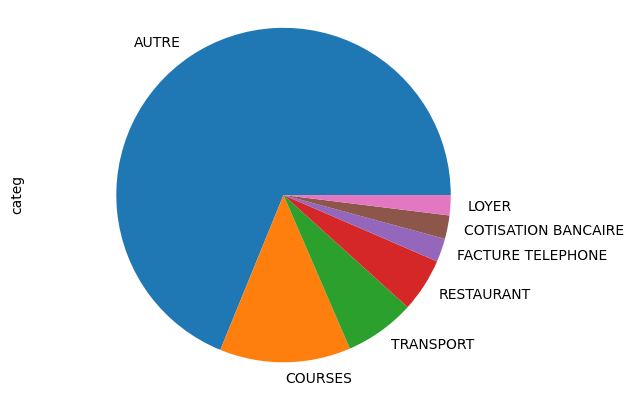

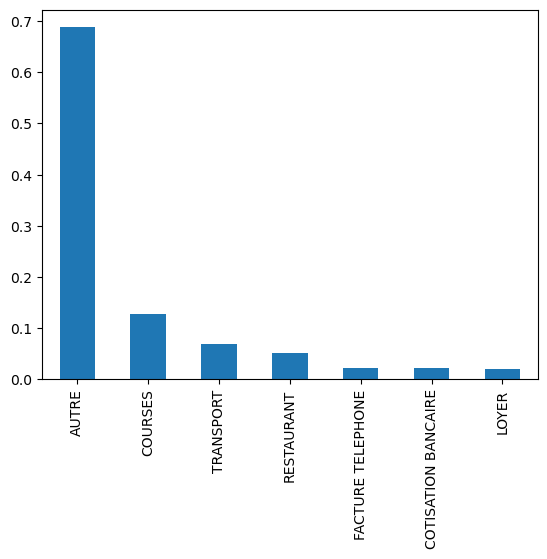

In [75]:
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()

À gauche, vous avez le diagramme en secteurs, plus connu sous le nom de diagramme en camembert. Si les francophones y voient un camembert (fleuron de la gastronomie française), les anglophones y voient plutôt une tarte, et l'appellent donc **pie chart**. Ici, l'angle de chaque secteur est proportionnel à l'effectif de chaque modalité.

À droite, c'est le diagramme en tuyaux d'orgue, appelé en anglais **bar chart**. La hauteur des tuyaux est égale à l'effectif de chaque modalité, ou bien (au choix) égale à la fréquence de chaque modalité, comme c'est le cas ici.

**2. Variables quantitatives**

Pour les **variables discrètes**, on les représente par un équivalent du diagramme en tuyaux d'orgue : **le diagramme en bâtons**. Cependant, avec les variables qualitatives, on pouvait placer les tuyaux un peu n'importe où sur l'axe horizontal. Mais avec une variable quantitative, on est contraint à placer précisément les bâtons sur l'axe horizontal. Comme on doit être précis, on préfère que les bâtons soient très fins. 

Pour représenter cela, nous allons créer une variable `quart_mois` pouvant prendre les valeurs 1, 2, 3 ou 4, et indiquant l'avancée dans le mois (1 : début, ..., 4 : fin de mois) :

In [76]:
data['quart_mois'] = [int((jour-1)*4/31)+1 for jour in data["date_operation"].dt.day]

On peut à présent représenter sa distribution :

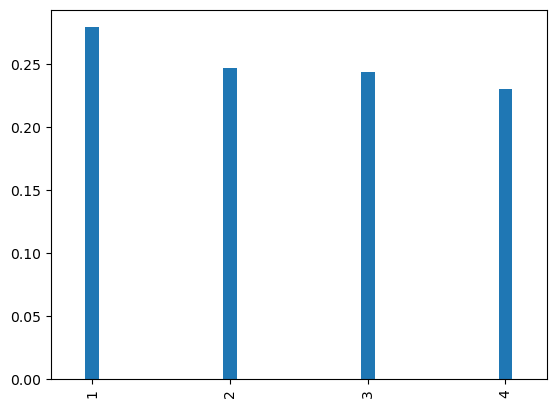

In [77]:
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

Pour les variables **continues**, on utilise l'histogramme, dans lequel les valeurs sont agrégées. Ici, comme on représente des classes (ou des intervalles, si vous préférez), on n'utilise plus de fins bâtons, mais des rectangles dont la largeur correspond à la largeur de la classe.

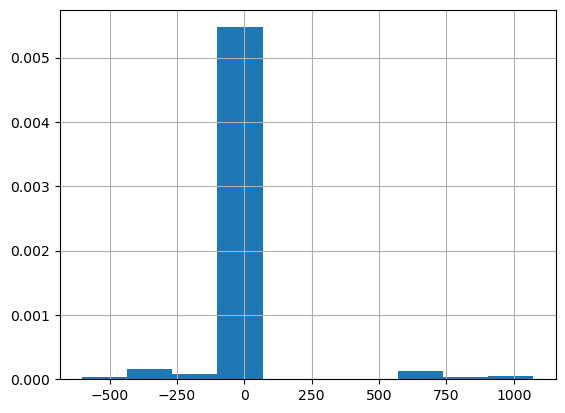

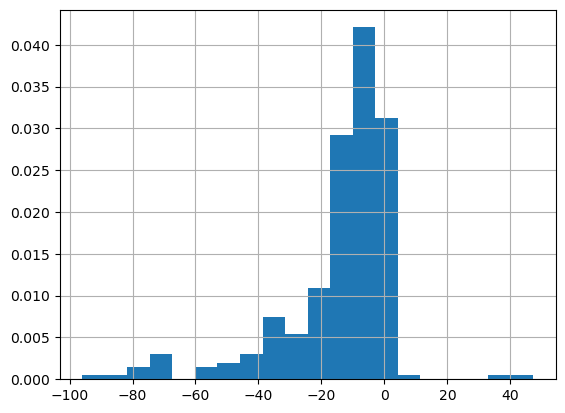

In [78]:
# Histogramme
data["montant"].hist(density=True)
plt.show()

# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

# <a name="C4"> P3C2 - Présentez une variable sous forme de tableau</a>

Voici le code qui a généré le tableau récapitulatif de la variable quart_mois.

In [79]:
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon

display(tab)

,quart_mois,n,f
0,1,86,0.279221
1,2,76,0.246753
2,3,75,0.243506
3,4,71,0.230519


Pour calculer les fréquences cumulées, il suffit de 2 lignes en plus. L'une trie les valeurs, et l'autre calcule la somme cumulée des fréquences :

In [80]:
tab = tab.sort_values("quart_mois") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée

display(tab)

,quart_mois,n,f,F
0,1,86,0.279221,0.279221
1,2,76,0.246753,0.525974
2,3,75,0.243506,0.769481
3,4,71,0.230519,1.000000


# <a name="C5"> P3C4 - Découvrez les mesures de tendance centrale</a>

En Python, le calcul du mode tient en une ligne. Voici un exemple avec la variable montant :

In [81]:
data['montant'].mode()

0   -1.6
Name: montant, dtype: float64

Voici comment calculer la moyenne des montants dépensés :

In [82]:
data['montant'].mean()

2.8725649350649407

Voilà comment calculer la médiane des montants :

In [83]:
data['montant'].median()

-9.6

Analysons un peu plus en détail notre variable montant.

Les montants des opérations sont très hétérogènes : il y a des dépenses (à montant négatif) parfois grosses (les loyers, par exemple), souvent petites (courses, téléphone, etc.), et il y a des rentrées d'argent (à montant positif), peu fréquentes mais grosses. Difficile donc d'interpréter la moyenne (très sensible aux valeurs atypiques) qui vaut ici 2,87 €.

On a le même problème pour la médiane qui vaut -9,6 €. Le fait qu'elle soit négative nous indique cependant qu'il y a plus de dépenses que d'entrées d'argent. Par contre, le mode nous indique que la plupart des opérations tournent autour de -1,6 €. Ici, les 3 mesures sont très éloignées les unes des autres.

Pour avoir des montants d'opérations plus homogènes, il serait intéressant de calculer ces mesures pour chaque catégorie d'opération : les montants devraient être moins éparpillés au sein d'une catégorie puisque les opérations sont de même nature. Je vous laisse le faire en Python. Vous pouvez réaliser cela via une boucle `for`, qui itérera sur chacune des catégories. Ne vous arrêtez cependant pas uniquement au code, essayez d'en tirer une dimension analytique : quelle interprétation pouvez-vous faire des résultats ?

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
Name: montant, dtype: float64


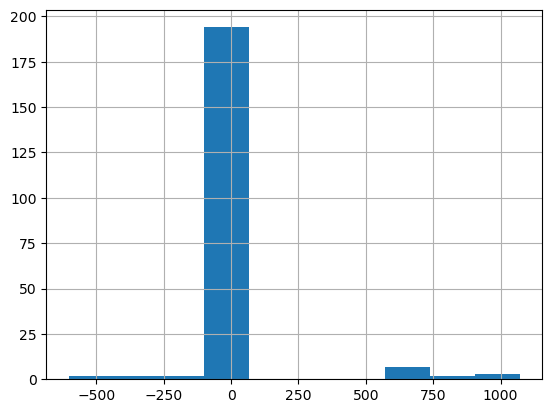

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64


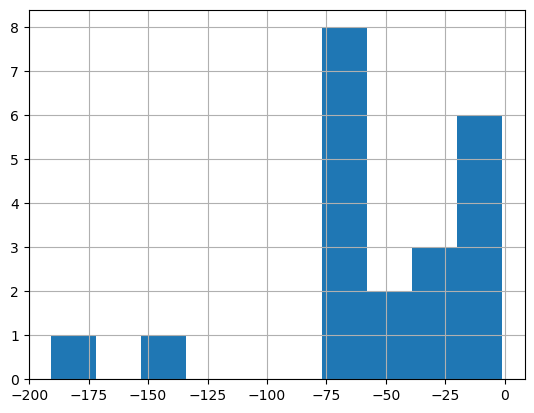

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64


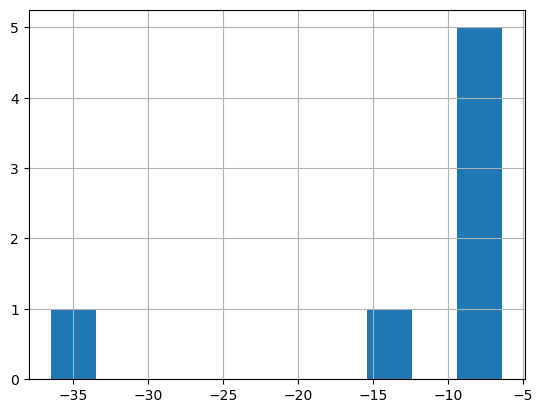

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64


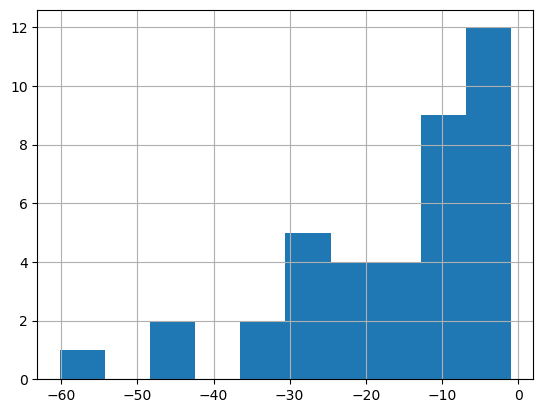

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64


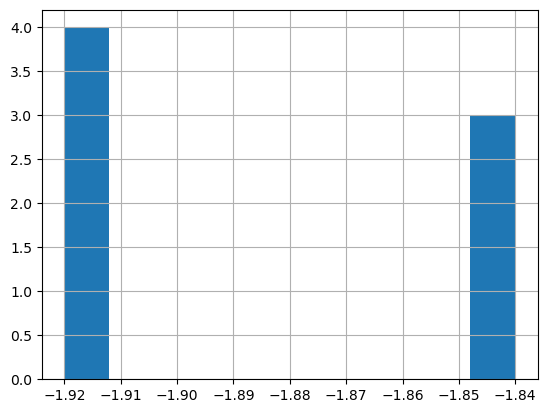

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64


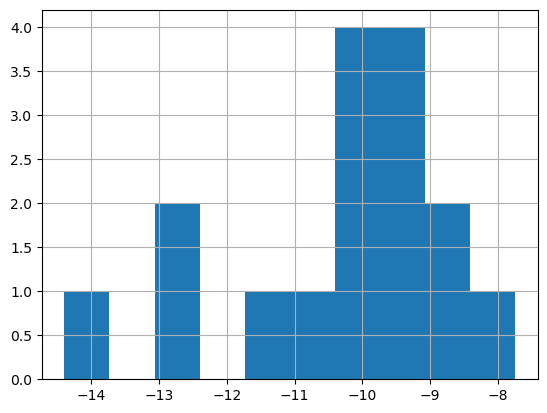

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64


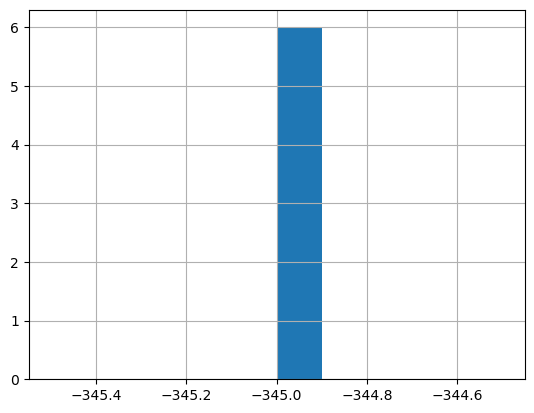

In [84]:
for cat in data["categ"].unique():
    subset = data.loc[data.categ == cat, :] # Création du sous-échantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    subset["montant"].hist() # Crée l'histogramme
    plt.show() # Affiche l'histogramme

Pour chaque catégorie, on crée un sous-échantillon (subset) qui contient uniquement les opérations de la catégorie en cours. On affiche en lignes 5 à 7 les 3 mesures, et on affiche également l'histogramme pour mettre en perspectives les 3 mesures. A vous d'interpréter vos résultats !

# <a name="C6">P3C5 - Comprenez les mesures de dispersion</a>

Pour calculer la variance en Python, cela se fait très facilement ! Il suffit d'utiliser la méthode .var() sur la variable considérée. Par exemple avec la variable montant :

In [85]:
data['montant'].var()

31007.638040630973

Aussi, vous trouverez souvent une version "corrigée" de la variance empirique, que l'on qualifie de non biaisée. En effet, quand on se plonge dans les calculs, on s'aperçoit que la variance empirique donne des valeurs qui (en moyenne) sont inférieures à la variance de la variable aléatoire. Il s'agit de la notion de biais d'un estimateur. Un estimateur sans biais est meilleur qu'un estimateur biaisé.

Pour corriger ce biais, on a créé la variance empirique corrigée, ou variance empirique sans biais. Voici comment calculer la variance empirique corrigée en Python :

In [86]:
data['montant'].var(ddof=0)

30906.963891148403

Voilà comment calculer l'écart-type de la variable montant :

In [87]:
data['montant'].std()

176.08985785851203

Mais lorsque vous faites un trajet, un écart-type de 6,55 minutes sur un trajet de 1 h (1h en moyenne), ce n'est pas la même chose qu'un écart-type de 6,55 minutes sur un trajet de 24 h (24h en moyenne) ! Pour remédier à cela, on a donc créé le coefficient de variation qui est l'écart-type empirique divisé par la moyenne.

Le calcul de ce dernier en Python est tout aussi simple :

In [88]:
data['montant'].std(ddof=0)

175.80376529286397

Nous pouvons facilement construire une boîte à moustaches avec Python :

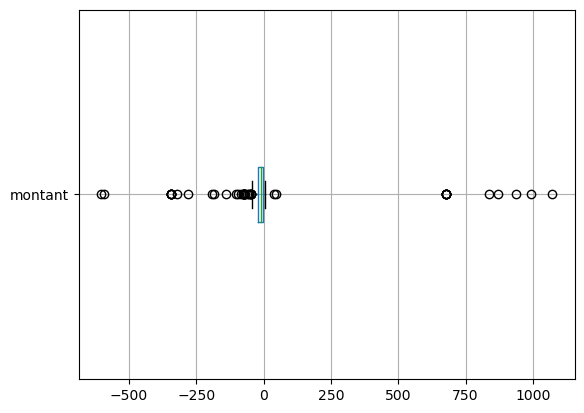

In [89]:
data.boxplot(column="montant", vert=False)
plt.show()

À votre tour ! Reprenez le code développé lors du chapitre précédent, en y ajoutant pour chaque catégorie :
- l'écart-type ;
- la variance ;
- un histogramme ;
- une boîte à moustache des montants.

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
Name: montant, dtype: float64
var:
 40401.82999254187
ect:
 201.00206464746046


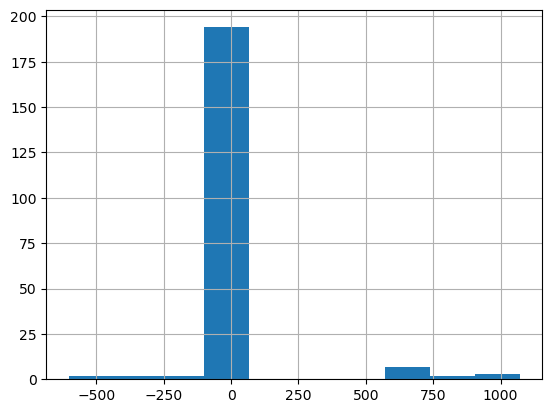

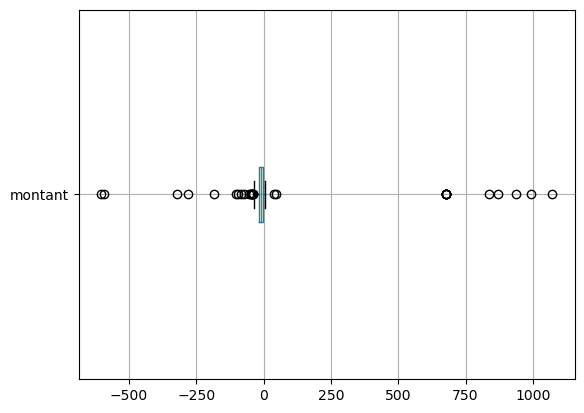

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64
var:
 2205.016868027212
ect:
 46.95760713694014


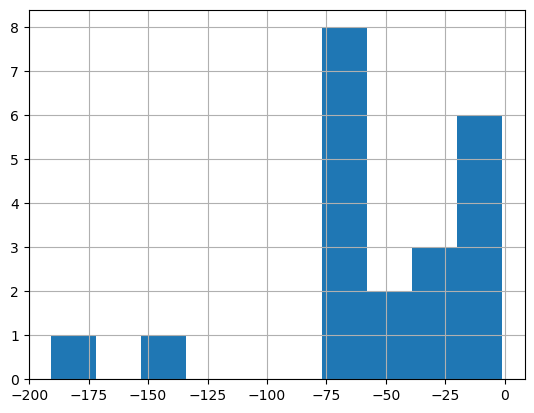

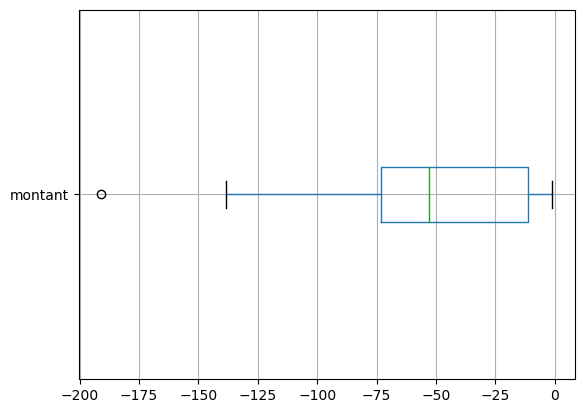

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317


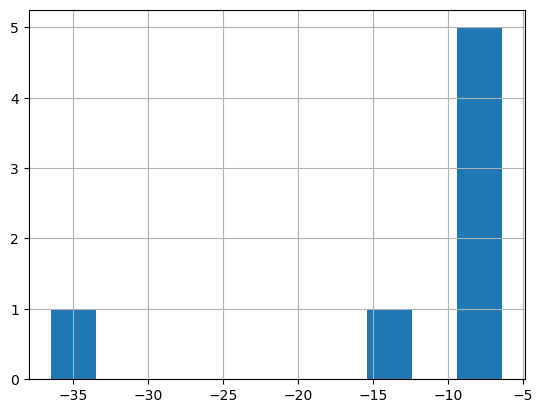

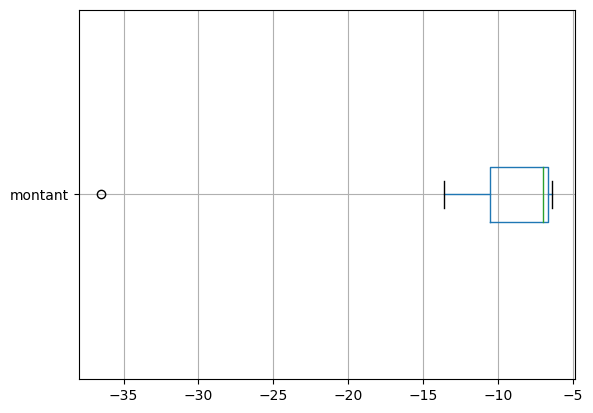

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64
var:
 177.02535476660088
ect:
 13.3050875520081


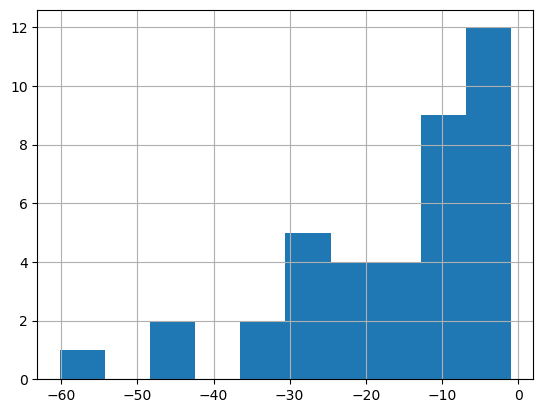

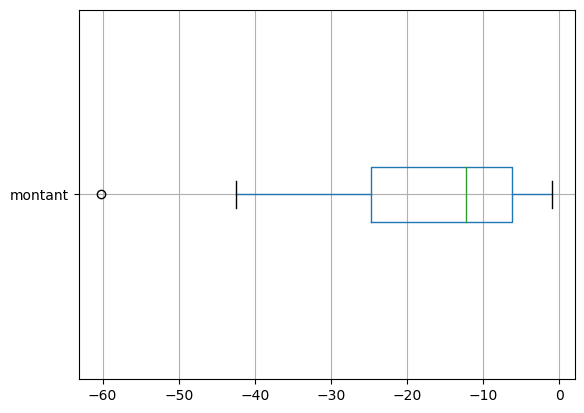

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141


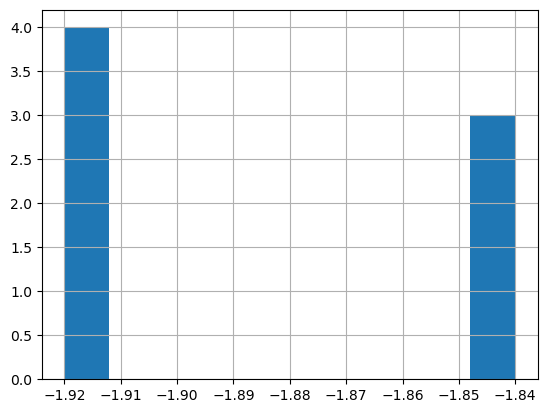

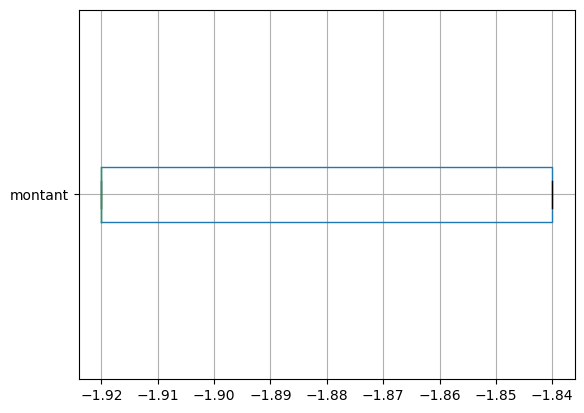

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64
var:
 2.853193750000001
ect:
 1.689139943876765


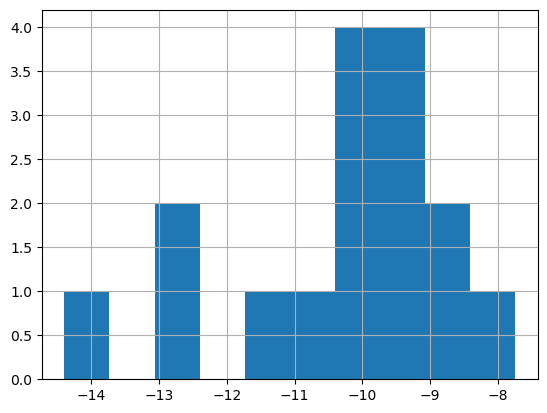

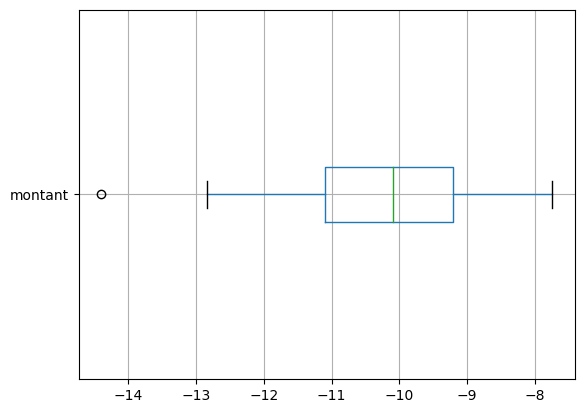

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64
var:
 0.0
ect:
 0.0


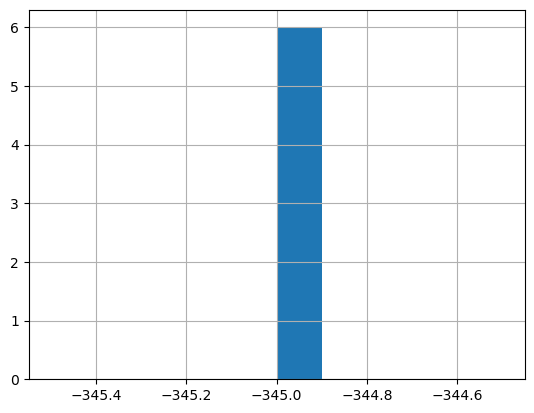

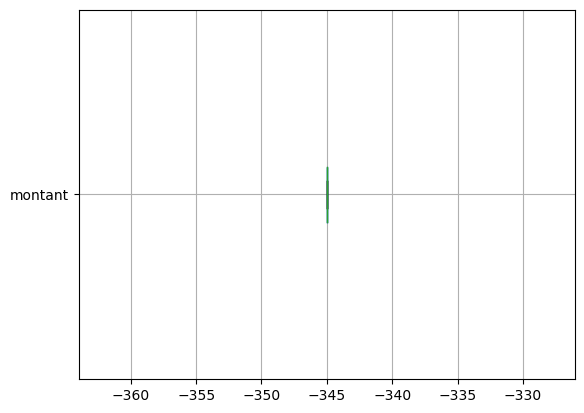

In [90]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

 La variance du montant des opérations de la catégorie LOYER est nulle, ce qui signifie que le montant du loyer est toujours resté fixe.

# <a name="C7"> P3C6 - Appréhendez les mesures de forme</a>

Le calcul du skewness se fait très facilement en Python :

In [91]:
data['montant'].skew()

3.3618450105098843

Voilà comment calculer le kurtosis de notre variable montant :

In [92]:
data['montant'].kurtosis()

17.2719048282677

Poussez encore votre analyse un peu plus loin ! Ajoutez le calcul du Skewness empirique et le Kurtosis empirique pour chaque catégorie.

--------------------
AUTRE
moy:
 23.433207547169832
med:
 -8.31
mod:
 0   -1.6
Name: montant, dtype: float64
var:
 40401.82999254187
ect:
 201.00206464746046
skw:
 3.1215325222336423
kur:
 12.716537970826295


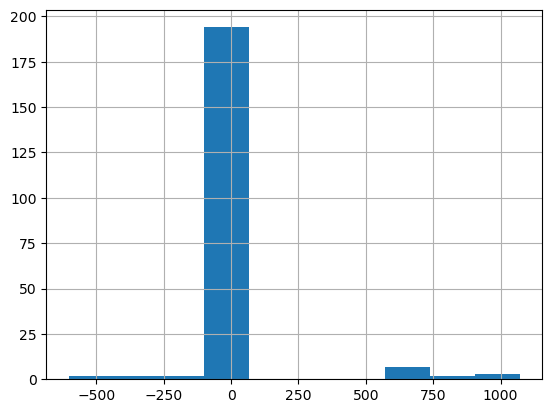

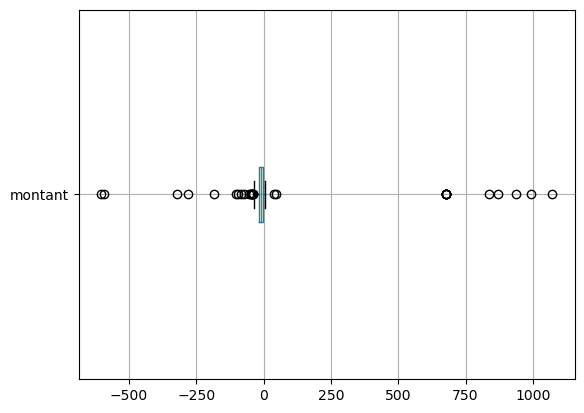

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64
var:
 2205.016868027212
ect:
 46.95760713694014
skw:
 -1.248265076217821
kur:
 2.1922705326917495


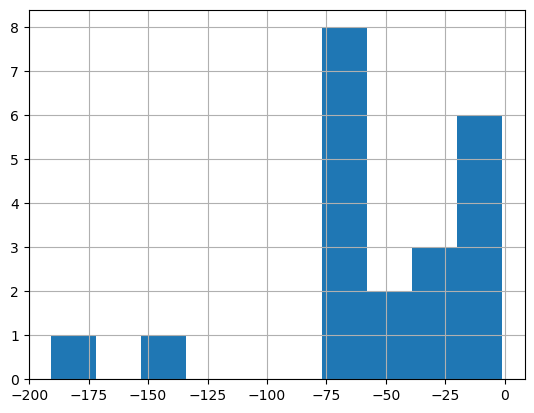

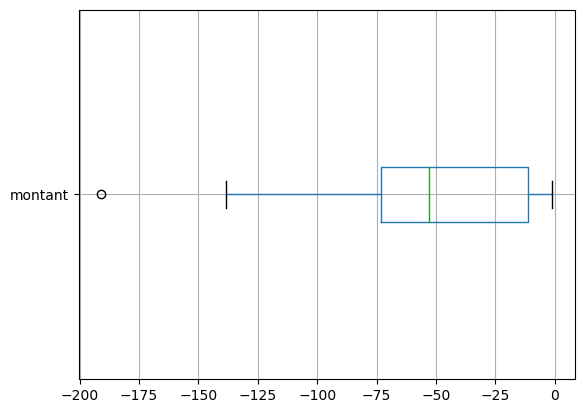

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317
skw:
 -2.3876514564281526
kur:
 5.798563367885492


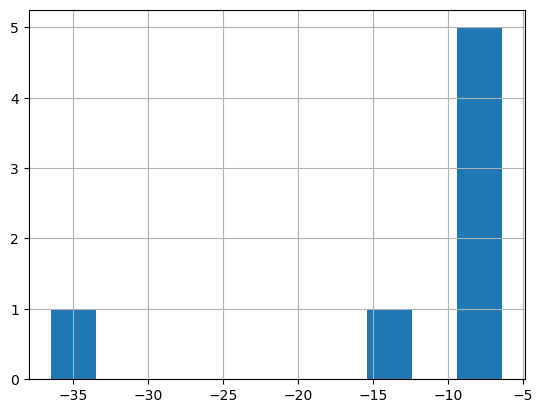

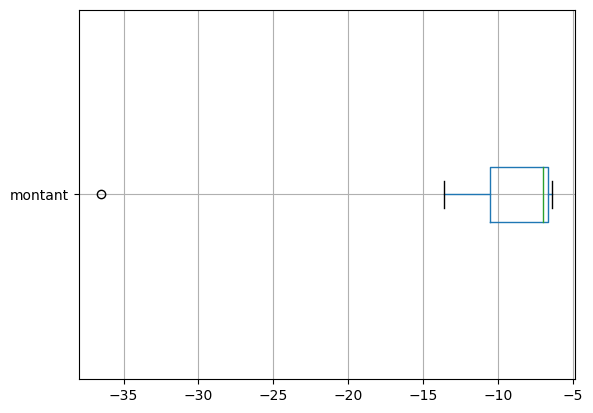

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64
var:
 177.02535476660088
ect:
 13.3050875520081
skw:
 -1.2467488306456982
kur:
 1.6047304940874998


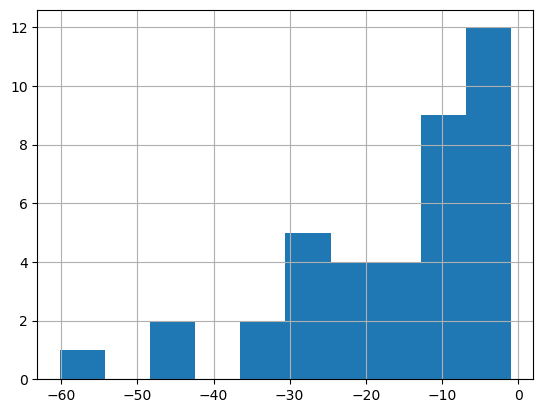

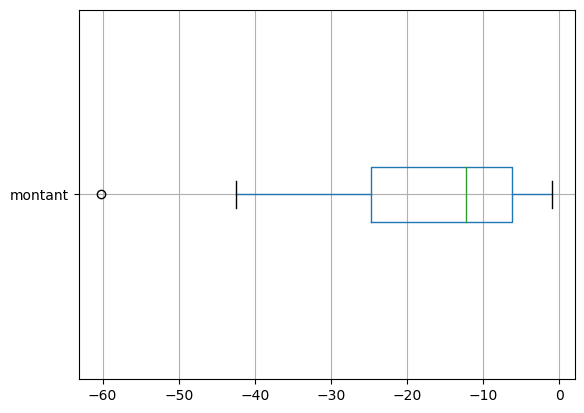

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141
skw:
 0.37416573867739106
kur:
 -2.800000000000003


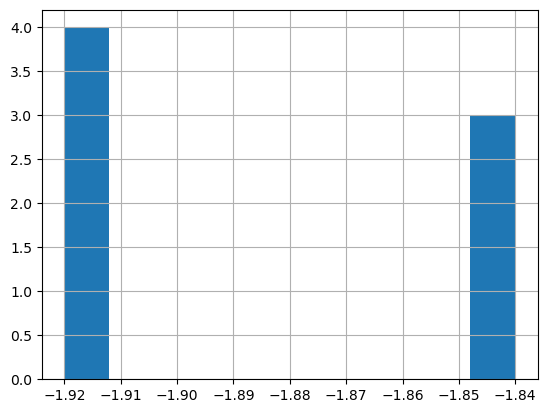

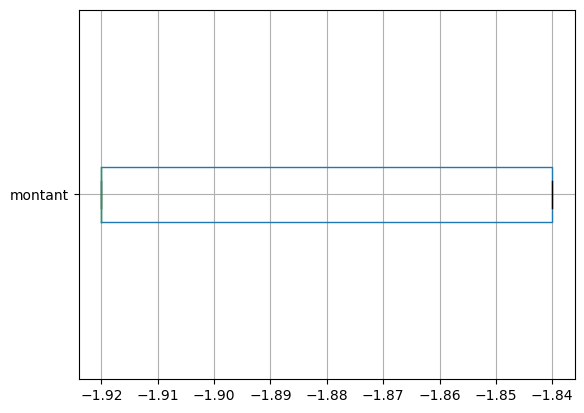

--------------------
RESTAURANT
moy:
 -10.332500000000001
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64
var:
 2.853193750000001
ect:
 1.689139943876765
skw:
 -0.8883503487158837
kur:
 0.5988855591691937


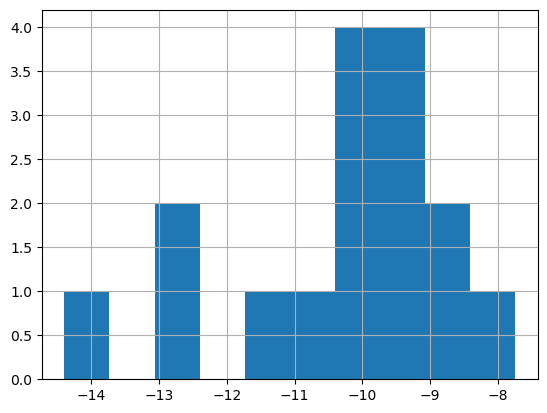

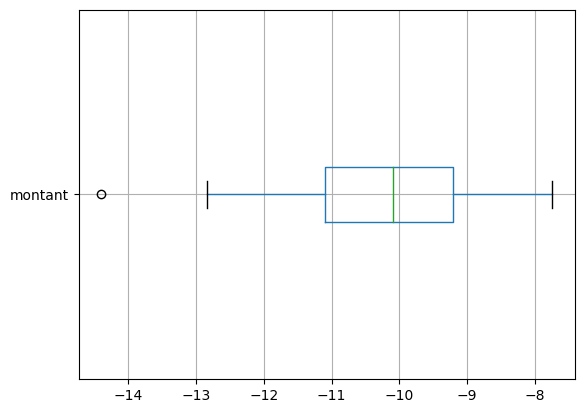

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0
kur:
 0


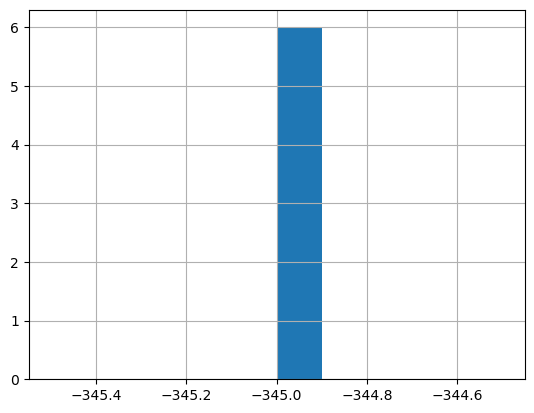

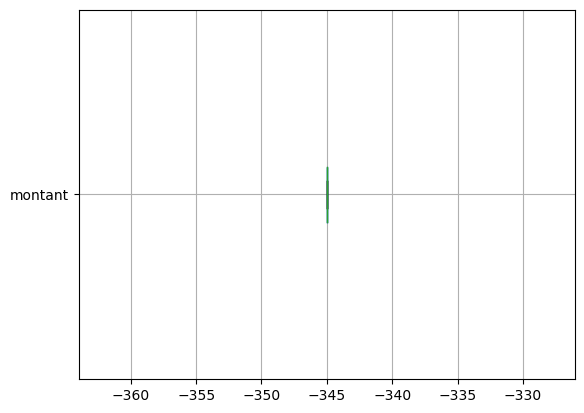

In [93]:
for cat in data["categ"].unique():
    subset = data[data.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    print("skw:\n",subset['montant'].skew())
    print("kur:\n",subset['montant'].kurtosis())
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

Pour toutes les opérations dont la catégorie regroupe principalement des dépenses (téléphone, courses, etc.), il est assez normal que le skewness empirique soit négatif. La distribution des dépenses s'étale vers la gauche, car on fait fréquemment des petites dépenses, et moins souvent des dépenses qui parfois peuvent être très importantes (donc très à gauche)

# <a name="C8">P3C7 - Familiarisez-vous avec les mesures de concentration</a>

Voici le code permettant d'afficher la courbe de Lorenz :

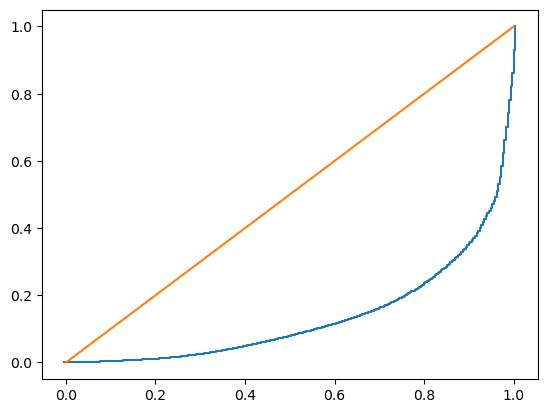

In [94]:
depenses = data[data['montant'] < 0]
dep = -depenses['montant'].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.show()

On y sélectionne tout d'abord le sous-échantillon de travail que l'on appelle  depenses  . Comme évoqué plus haut, il faut trier les individus dans l'ordre croissant des valeurs de la variable ; nous le faisons ici grâce à `np.sort(dep)`, car  dep  contient les observations de la variable montant.

Ensuite, nous calculons la somme cumulée grâce à  `np.cumsum()`. Pour normaliser et faire en sorte que le haut de la courbe soit à 1, on divise le tout par  `dep.sum()`. La variable  lorenz  contient les ordonnées des points, mais il nous faut maintenant leurs abscisses : celles-ci s'étendent de 0 à 1 (comme évoqué précédemment) à intervalle réguliers. C'est ce que produit  `np.linspace(0-1/n,1+1/n,len(lorenz))`

Le calcul de l'indice de Gini reprend directement les variables issues du traçage de la courbe de Lorenz mais est un peu plus complexe à comprendre, je laisse les plus courageux s'y plonger ;)

In [95]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.7204386813739185

# <a name="C9"> P4C3 - Analysez la corrélation entre deux variables quantitatives</a>

Posons-nous la question suivante :

    Êtes-vous moins dépensier lorsque vous avez peu d'argent sur votre compte ?

Vous l'aurez deviné, les 2 variables à étudier sont : montant et solde_avt_operation. Rechercher une corrélation entre ces variables revient à dire : "Sachant que le solde de votre compte est petit, peut-on s'attendre à ce que le montant de l'opération soit lui aussi petit ?" (ou l'inverse).

Je vous invite donc à tracer le diagramme de dispersion entre le solde avant opération et le montant des dépenses, et analyser ce qui en ressort.

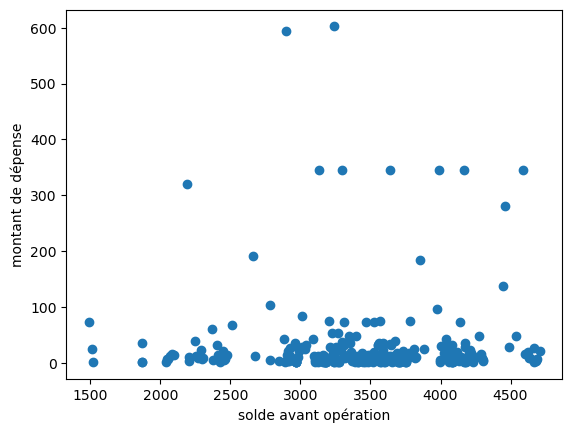

In [96]:
depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o')
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

A priori sur ce diagramme de dispersion, il ne semble pas que quand le solde est petit, les montants soient particulièrement petits. Il semble ne pas y avoir de corrélation. Mais vous en trouverez peut-être une dans vos propres relevés !

Pour avoir une représentation plus efficace que le scatter plot, il est possible d'agréger la variable X en abscisse (axe horizontal) en différentes classes. Cela équivaut à "découper" au couteau le graphique précédent en tranches verticales. On représente ensuite pour chaque tranche une boîte à moustaches calculée à partir de tous les points présents dans la tranche. Voici donc le nouveau graphique obtenu :

In [97]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

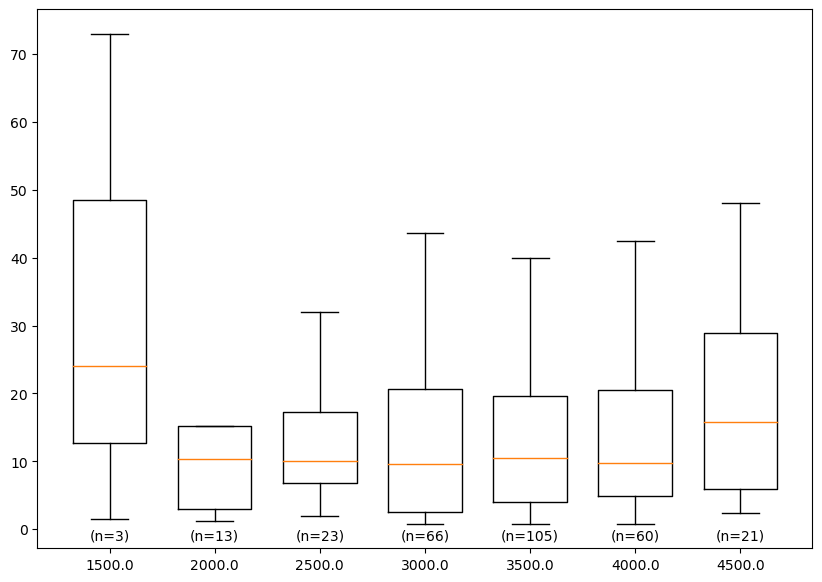

In [98]:
for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    solde_avt_ope = depenses.loc[indices==ind,"solde_avt_ope"]
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'solde_avt_ope': solde_avt_ope,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

plt.figure(figsize=(10,7))
        
# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7) # largeur graphique des boxplots

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

Pour calculer le coefficient de Pearson et la covariance, 2 lignes suffisent !

In [99]:
groupes

[{'valeurs': 0     1.44
  1    24.00
  2    73.00
  Name: montant, dtype: float64,
  'solde_avt_ope': 0    1515.25
  1    1513.81
  2    1489.81
  Name: solde_avt_ope, dtype: float64,
  'centre_classe': 1500.0,
  'taille': 3,
  'quartiles': [12.72, 24.0, 48.5]},
 {'valeurs': 5       14.39
  6       15.20
  7       12.00
  8        7.02
  9        6.80
  10       1.84
  294     40.00
  295      2.93
  296     10.36
  297    320.00
  298      1.20
  299      1.76
  300     36.00
  Name: montant, dtype: float64,
  'solde_avt_ope': 5      2097.61
  6      2083.22
  7      2068.02
  8      2056.02
  9      2049.00
  10     2042.20
  294    2244.87
  295    2204.87
  296    2201.94
  297    2191.58
  298    1871.58
  299    1870.38
  300    1868.62
  Name: solde_avt_ope, dtype: float64,
  'centre_classe': 2000.0,
  'taille': 13,
  'quartiles': [2.93, 10.36, 15.2]},
 {'valeurs': 168     12.48
  169    190.80
  170     13.60
  171      6.49
  172      4.80
  173     20.80
  174      9.20
  175

In [100]:
print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.010068819133759187
484.95954154532865


# <a name="C10"> P4C4 - Analysez deux variables quantitatives par régression linéaire</a>

Tout d'abord, il faut calculer la variable attente ! Voici le code permettant de créer cela :

In [101]:
# Selection du sous-échantillon
courses = data.loc[data.categ == "COURSES", :]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})

On crée ici au final un sous-échantillon qui ne contient que les opérations de catégorie courses, et que l'on appelle...  courses  !

Essayons d'afficher le diagramme de dispersion avec X = attente et Y = montant, et regardons si tous les points sont alignés :

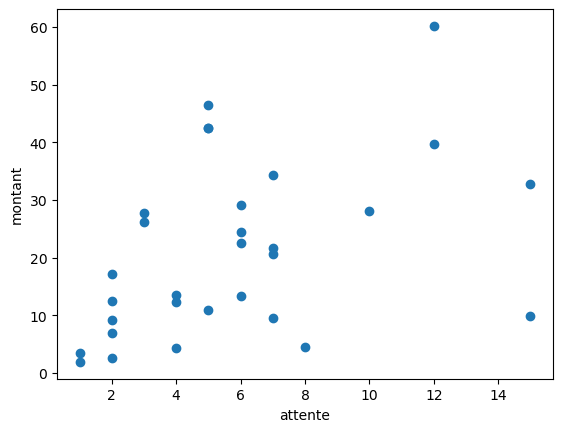

In [102]:
plt.plot(courses['attente'],courses['montant'], "o")
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

On peut à présent effectuer notre régression linéaire. Voici comment estimer a et b avec Python. Le code est un peu complexe, mais retenez que la dernière ligne crée les variables  a  et  b  contenant les estimations.

In [103]:
import statsmodels.api as sm

Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

Voici comment tracer la droite de régression à partir des coefficients obtenus :

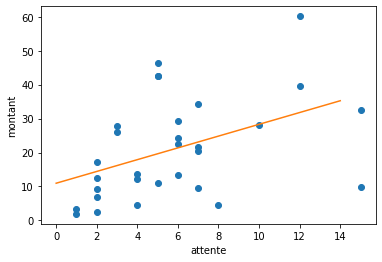

In [46]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

Régression linéaire sans les outliers :

attente      3.030823
intercept    5.411480
dtype: float64


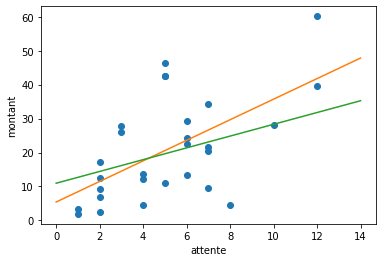

In [47]:
courses = courses.loc[courses['attente'] < 15, :]

Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a_new,b_new = result.params['attente'],result.params['intercept']

print(result.params)

plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a_new*x+b_new for x in np.arange(15)])
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()


# <a name="C11"> P4C5 - Analysez une variable quantitative et une qualitative par ANOVA</a>

Voici le code qui permet de représenter une variable quantitative et une variable qualitative. Tout d'abord, créez le sous-échantillon sur lequel vous souhaitez travailler en adaptant ce code, notamment les variables X et Y selon la question que vous aurez choisie parmi celles ci-dessus.

In [48]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data.loc[data["montant"] < 0, :].copy()
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon.loc[sous_echantillon["categ"] != "LOYER", :] 

Ensuite, ces quelques lignes de code affichent votre graphique !

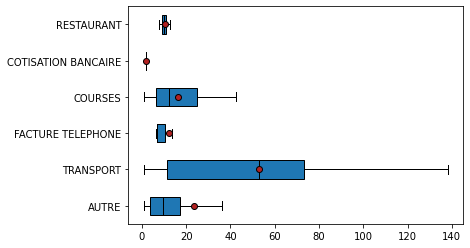

In [49]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Les points rouges au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.

On voit ici que les montants sont très différents d'une catégorie à l'autre. Par exemple, les montants des dépenses de transport sont plus élevés et plus dispersés que ceux des factures téléphoniques. Mais vérifions maintenant cette affirmation par les chiffres, grâce à une modélisation.

Voici à présent le code permettant de calculer $\eta^2$ (eta carré ou eta squared, en anglais). Je vous propose ici de faire le calcul à la main ;) :

In [50]:
X = "categ" # qualitative
Y = "montant" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.027522800301841496

On va aller plus loin en analysant la corrélation entre la variable quart_mois créée précédemment et le montant des achats. En effet, il serait intéressant de déterminer si certains jours sont plus "propices" à la dépense que d'autres et pourquoi pas, essayer de dégager les raisons !

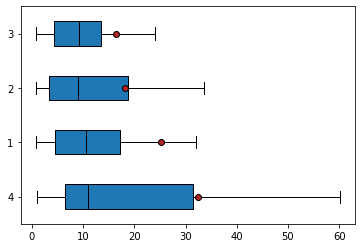

0.01139803800931087

In [51]:
X = "quart_mois" # qualitative
Y = "montant" # quantitative

modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

eta_squared(sous_echantillon[X],sous_echantillon[Y])

# <a name="C12"> P4C6 - Analysez deux variables qualitatives avec le Chi-2</a>

Pour répondre à ces questions, vous pouvez afficher le tableau de contingence comme ceci :

In [52]:
X = "quart_mois"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,AUTRE,COTISATION BANCAIRE,COURSES,FACTURE TELEPHONE,LOYER,RESTAURANT,TRANSPORT,Total
quart_mois,,,,,,,,
1,55.0,7.0,6.0,6.0,NaN,3.0,9.0,86
2,45.0,NaN,11.0,1.0,6.0,7.0,6.0,76
3,60.0,NaN,7.0,NaN,NaN,4.0,4.0,75
4,52.0,NaN,15.0,NaN,NaN,2.0,2.0,71
Total,212.0,7.0,39.0,7.0,6.0,16.0,21.0,308


Voici le code affichant cette heatmap :

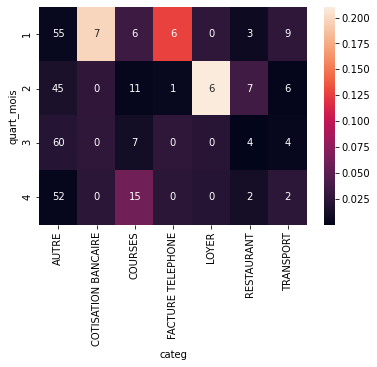

In [53]:
import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()